In [3]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn import metrics
from datetime import datetime
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import model_to_dot
from keras.utils import plot_model
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from statistics import variance
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,ExtraTreesClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV
from sklearn.feature_selection import RFE
from xgboost import cv
from sklearn.metrics import make_scorer

In [4]:
House_dataset=pd.read_csv("House_dataset.csv")

## Creating Training and Test Sets House dataset

In [5]:
X=House_dataset.drop(['List Price', 'Sold Price', 'Days on Market','Sale to List %','price class', 'log price'],axis=1)
Y=House_dataset[['Sold Price','log price',"price class"]]

In [6]:
from sklearn.preprocessing import StandardScaler
def X_norm(df):
    ndf=pd.DataFrame()
    for col in df.columns:
        #norm btw 0 and 1
        ndf[col]=df[col]/max(df[col])
    #Z_score for 'Taxes' and 'Maint. Fees'
    std_scaler = StandardScaler()
    ndf[['Taxes']] = std_scaler.fit_transform(ndf[['Taxes']].values.tolist())
    return ndf

nX=X_norm(X)
nY=Y.copy(deep=True)
_MAX_Y=max(Y['Sold Price'])
nY['Sold Price']=Y['Sold Price']/_MAX_Y

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(nX, nY, test_size=0.15,stratify=nY[["price class"]])

In [8]:
def error_summary(y_true, y_pred):
    MAPE=np.average(np.abs(y_true - y_pred) / y_true, axis=0)*100
    RMSE=np.sqrt(mean_squared_error(y_true, y_pred))
    R2=r2_score(y_true, y_pred)
    APE=np.abs(y_true - y_pred) / y_true
    acc=sum(APE<0.2)/len(APE)
    dict_error={'Value':[R2,_MAX_Y*RMSE,MAPE,acc]}
    index_error=['R2','RMSE','MAPE',"ACC(APE<20%)"]
    df = pd.DataFrame(dict_error,index=index_error)
    return round(df,2).T

def APE_hist(title,y_true, y_pred):
    APE=(np.abs(y_true - y_pred) / y_true)
    plt.hist(100*APE,bins=range(100),density=True,cumulative=True)
    plt.title(title)
    plt.xlabel('APE')
    plt.ylabel('cumulative distribution')
    
def GS_score(y, y_pred):
    ES=error_summary(y,y_pred)
    return ES["ACC(APE<20%)"].values

def Log_GS_score(y, y_pred):
    ES=error_summary(np.exp(y),np.exp(y_pred))
    return ES["ACC(APE<20%)"].values

    

In [7]:
#X["Date"].value_counts().sort_index()

In [8]:
## Linear Regression Model

         R2       RMSE  MAPE  ACC(APE<20%)
Value  0.84  204761.09  13.0          0.79


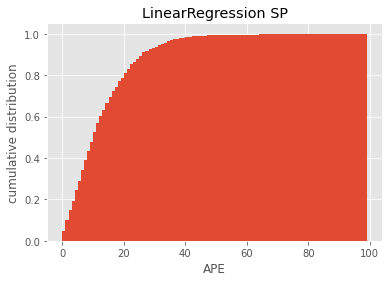

In [9]:
LR= LinearRegression()
LR.fit(X_train, Y_train['Sold Price'])
y_pred=LR.predict(X_test)
print(error_summary(Y_test['Sold Price'],y_pred))
APE_hist("LinearRegression SP",Y_test['Sold Price'], y_pred)

         R2       RMSE   MAPE  ACC(APE<20%)
Value  0.79  229291.96  12.74           0.8


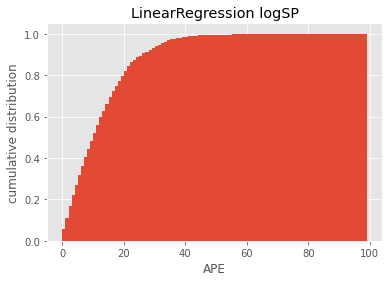

In [10]:
LR= LinearRegression()
LR.fit(X_train, Y_train['log price'])
y_pred=np.exp(LR.predict(X_test))/_MAX_Y
print(error_summary(Y_test['Sold Price'],y_pred))
APE_hist("LinearRegression logSP",Y_test['Sold Price'], y_pred)

In [11]:
#KFold

In [12]:
Kf_R2=[]
Kf_RMSE=[]
Kf_MAPE=[]
Kf_ACC=[]
folds = KFold(n_splits = 50, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    LR= LinearRegression().fit(nX.iloc[train_index], nY.iloc[train_index]['Sold Price'])
    y_pred=LR.predict(nX.iloc[test_index])
    ES=error_summary(nY.iloc[test_index]['Sold Price'],y_pred)
    Kf_R2.append(ES['R2'].values)
    Kf_RMSE.append(ES['RMSE'].values)
    Kf_MAPE.append(ES['MAPE'].values)
    Kf_ACC.append(ES["ACC(APE<20%)"].values) 
print(f"R2={round(np.mean(Kf_R2),3)}({round(np.std(Kf_R2),3)})") 
print(f"RMSE={round(np.mean(Kf_RMSE))}({round(np.std(Kf_RMSE))})") 
print(f"MAPE={round(np.mean(Kf_MAPE),3)}({round(np.std(Kf_MAPE),3)})")
print(f"ACC(APE<20%)={round(np.mean( Kf_ACC),3)}({round(np.std( Kf_ACC),3)})") 

R2=0.84(0.02)
RMSE=201330(16105)
MAPE=13.01(0.613)
ACC(APE<20%)=0.791(0.028)


In [13]:
Kf_R2=[]
Kf_RMSE=[]
Kf_MAPE=[]
Kf_ACC=[]
folds = KFold(n_splits = 50, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    LR= LinearRegression().fit(nX.iloc[train_index], nY.iloc[train_index]['log price'])
    y_pred=np.exp(LR.predict(nX.iloc[test_index]))/_MAX_Y
    ES=error_summary(nY.iloc[test_index]['Sold Price'],y_pred)
    Kf_R2.append(ES['R2'].values)
    Kf_RMSE.append(ES['RMSE'].values)
    Kf_MAPE.append(ES['MAPE'].values)
    Kf_ACC.append(ES["ACC(APE<20%)"].values) 
print(f"R2={round(np.mean(Kf_R2),3)}({round(np.std(Kf_R2),3)})") 
print(f"RMSE={round(np.mean(Kf_RMSE))}({round(np.std(Kf_RMSE))})") 
print(f"MAPE={round(np.mean(Kf_MAPE),3)}({round(np.std(Kf_MAPE),3)})")
print(f"ACC(APE<20%)={round(np.mean( Kf_ACC),3)}({round(np.std( Kf_ACC),3)})") 

R2=0.791(0.032)
RMSE=230201(22856)
MAPE=12.857(0.646)
ACC(APE<20%)=0.792(0.027)


## KNN

## GridSearch

In [14]:
# Sold Prce

ACC = make_scorer(GS_score)
parameters = {'n_neighbors':range(6,19)}
KNN_base = KNeighborsRegressor(weights='distance',algorithm='brute', p=1,metric='minkowski') 
KNN_tuned = GridSearchCV(KNN_base, parameters,cv = 5,scoring= ACC)
KNN_opt=KNN_tuned.fit(X_train, Y_train['Sold Price'])
print("Best ACC(APE<20%): " + str(KNN_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(KNN_opt.best_estimator_) + "\n")
print(KNN_opt.best_params_)

Best ACC(APE<20%): 0.792

Optimal Model:
KNeighborsRegressor(algorithm='brute', n_neighbors=7, p=1, weights='distance')

{'n_neighbors': 7}


In [15]:
grid_predictions = KNN_opt.predict(X_test)
print(error_summary(Y_test['Sold Price'],grid_predictions))
APE_hist("KNN SP gridSearch",Y_test['Sold Price'],grid_predictions)

         R2       RMSE   MAPE  ACC(APE<20%)
Value  0.84  204248.28  12.64           0.8


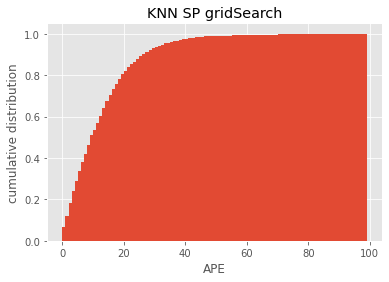

In [17]:
# log price

In [18]:
ACC = make_scorer(Log_GS_score)
parameters = {'n_neighbors':range(6,19)}
KNN_base = KNeighborsRegressor(weights='distance',algorithm='brute', p=1,metric='minkowski') 
KNN_tuned = GridSearchCV(KNN_base, parameters,cv = 5,scoring= ACC)
KNN_opt=KNN_tuned.fit(X_train, Y_train['log price'])
print("Best ACC(APE<20%): " + str(KNN_opt.best_score_) + "\n")
print("Optimal Model:\n" + str(KNN_opt.best_estimator_) + "\n")
print(KNN_opt.best_params_)

Best ACC(APE<20%): 0.798

Optimal Model:
KNeighborsRegressor(algorithm='brute', n_neighbors=7, p=1, weights='distance')

{'n_neighbors': 7}


In [19]:

grid_predictions = np.exp(KNN_opt.predict(X_test))/_MAX_Y
print(error_summary(Y_test['Sold Price'],grid_predictions))
APE_hist("KNN LogPrice gridSearch",Y_test['Sold Price'],grid_predictions)

         R2       RMSE   MAPE  ACC(APE<20%)
Value  0.83  207221.55  12.51          0.81


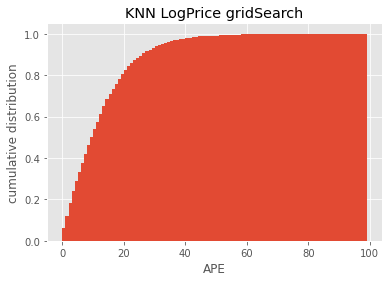

In [21]:
# K-Fold for sold price

In [30]:
Kf_R2=[]
Kf_RMSE=[]
Kf_MAPE=[]
Kf_ACC=[]
folds = KFold(n_splits = 50, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    KNN= KNeighborsRegressor(n_neighbors=7,weights='distance',algorithm='brute', p=1,metric='minkowski').fit(nX.iloc[train_index], nY.iloc[train_index]['Sold Price'])
    y_pred=KNN.predict(nX.iloc[test_index])
    ES=error_summary(nY.iloc[test_index]['Sold Price'],y_pred)
    Kf_R2.append(ES['R2'].values)
    Kf_RMSE.append(ES['RMSE'].values)
    Kf_MAPE.append(ES['MAPE'].values)
    Kf_ACC.append(ES["ACC(APE<20%)"].values) 
print(f"R2={round(np.mean(Kf_R2),3)}({round(np.std(Kf_R2),3)})") 
print(f"RMSE={round(np.mean(Kf_RMSE))}({round(np.std(Kf_RMSE))})") 
print(f"MAPE={round(np.mean(Kf_MAPE),3)}({round(np.std(Kf_MAPE),3)})")
print(f"ACC(APE<20%)={round(np.mean( Kf_ACC),3)}({round(np.std( Kf_ACC),3)})") 

R2=0.84(0.025)
RMSE=200560(16515)
MAPE=12.672(0.708)
ACC(APE<20%)=0.8(0.024)


In [31]:
# K_Fold for log price
Kf_R2=[]
Kf_RMSE=[]
Kf_MAPE=[]
Kf_ACC=[]
folds = KFold(n_splits = 50, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(nX, nY):
    KNN= KNeighborsRegressor(n_neighbors=7,weights='distance',algorithm='brute', p=1,metric='minkowski').fit(nX.iloc[train_index], nY.iloc[train_index]['log price'])
    y_pred=np.exp(KNN.predict(nX.iloc[test_index]))/_MAX_Y
    ES=error_summary(nY.iloc[test_index]['Sold Price'],y_pred)
    Kf_R2.append(ES['R2'].values)
    Kf_RMSE.append(ES['RMSE'].values)
    Kf_MAPE.append(ES['MAPE'].values)
    Kf_ACC.append(ES["ACC(APE<20%)"].values) 
print(f"R2={round(np.mean(Kf_R2),3)}({round(np.std(Kf_R2),3)})") 
print(f"RMSE={round(np.mean(Kf_RMSE))}({round(np.std(Kf_RMSE))})") 
print(f"MAPE={round(np.mean(Kf_MAPE),3)}({round(np.std(Kf_MAPE),3)})")
print(f"ACC(APE<20%)={round(np.mean( Kf_ACC),3)}({round(np.std( Kf_ACC),3)})") 

R2=0.837(0.027)
RMSE=201990(17251)
MAPE=12.435(0.7)
ACC(APE<20%)=0.809(0.025)


In [24]:
# Linear 

In [25]:
LR = LinearRegression()
LR.fit(X_train, Y_train['Sold Price'])
dict_coef={'Coefficients':LR.coef_}
index_coef=X_train.columns
df = pd.DataFrame(dict_coef,index=index_coef)
df.T


,Bedrooms AG,Bedrooms BG,Washrooms,Family Room,Parking Type,Taxes,AC Type,green_new,Date,MortgageRate,...,E09,C13,W10,W05,E06,E02,C09,E01,W01,E07
Coefficients,0.039037,-0.007638,0.15314,0.008778,0.003674,0.103579,0.007269,0.036863,0.076286,-1.049305,...,1.383751e+07,1.383751e+07,1.383751e+07,1.383751e+07,1.383751e+07,1.383751e+07,1.383751e+07,1.383751e+07,1.383751e+07,1.383751e+07


## Hybrid

         R2       RMSE   MAPE  ACC(APE<20%)
Value  0.85  193617.66  11.41          0.84


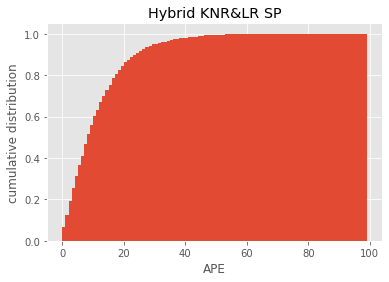

In [26]:
LR = LinearRegression()
LR.fit(X_train, Y_train['Sold Price'])
weights=np.abs(LR.coef_)/np.sum(np.abs(LR.coef_))
KNN= KNeighborsRegressor(n_neighbors=8, weights='distance',
                          algorithm='brute', metric='wminkowski',
                          metric_params={'w': weights},p=1)
KNN.fit(X_train, Y_train['Sold Price'])
y_pred=KNN.predict(X_test)
print(error_summary(Y_test['Sold Price'],y_pred))
APE_hist("Hybrid KNR&LR SP",Y_test['Sold Price'], y_pred)

         R2       RMSE   MAPE  ACC(APE<20%)
Value  0.85  195009.53  11.25          0.84


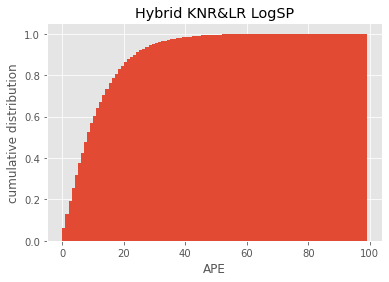

In [27]:
LR = LinearRegression()
LR.fit(X_train, Y_train['Sold Price'])
weights=np.abs(LR.coef_)/np.sum(np.abs(LR.coef_))
KNN= KNeighborsRegressor(n_neighbors=8, weights='distance',
                          algorithm='brute', metric='wminkowski',
                          metric_params={'w': weights},p=1)
KNN.fit(X_train, Y_train['log price'])
y_pred=np.exp(KNN.predict(X_test))/_MAX_Y
print(error_summary(Y_test['Sold Price'],y_pred))
APE_hist("Hybrid KNR&LR LogSP",Y_test['Sold Price'], y_pred)

In [19]:
Kf_R2=[]
Kf_RMSE=[]
Kf_MAPE=[]
Kf_ACC=[]
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(X, Y):
    LR = LinearRegression()
    LR.fit(nX.iloc[train_index], nY.iloc[train_index]['Sold Price'])
    weights=np.abs(LR.coef_)/np.sum(np.abs(LR.coef_))
    KNN_LR=KNeighborsRegressor(n_neighbors=6, weights='distance', algorithm='brute', metric='wminkowski',metric_params={'w': weights},p=1).fit(nX.iloc[train_index], nY.iloc[train_index]['Sold Price'])
    y_pred=KNN_LR.predict(nX.iloc[test_index])
    ES=error_summary(nY.iloc[test_index]['Sold Price'],y_pred)
    Kf_R2.append(ES['R2'].values)
    Kf_RMSE.append(ES['RMSE'].values)
    Kf_MAPE.append(ES['MAPE'].values)
    Kf_ACC.append(ES["ACC(APE<20%)"].values) 
print(f"R2={round(np.mean(Kf_R2),3)}({round(np.std(Kf_R2),3)})") 
print(f"RMSE={round(np.mean(Kf_RMSE))}({round(np.std(Kf_RMSE))})") 
print(f"MAPE={round(np.mean(Kf_MAPE),3)}({round(np.std(Kf_MAPE),3)})")
print(f"ACC(APE<20%)={round(np.mean( Kf_ACC),3)}({round(np.std( Kf_ACC),3)})") 

R2=0.856(0.005)
RMSE=190070(2488)
MAPE=11.568(0.218)
ACC(APE<20%)=0.836(0.005)


In [18]:
Kf_R2=[]
Kf_RMSE=[]
Kf_MAPE=[]
Kf_ACC=[]
folds = KFold(n_splits =5, shuffle = True, random_state = 100)
for train_index, test_index in folds.split(X, Y):
    LR = LinearRegression()
    LR.fit(nX.iloc[train_index], nY.iloc[train_index]['Sold Price'])
    weights=np.abs(LR.coef_)/np.sum(np.abs(LR.coef_))
    KNN_LR=KNeighborsRegressor(n_neighbors=10, weights='distance', algorithm='brute', metric='wminkowski',metric_params={'w': weights},p=1).fit(nX.iloc[train_index], nY.iloc[train_index]['log price'])
    y_pred=np.exp(KNN_LR.predict(nX.iloc[test_index]))/_MAX_Y
    ES=error_summary(nY.iloc[test_index]['Sold Price'],y_pred)
    Kf_R2.append(ES['R2'].values)
    Kf_RMSE.append(ES['RMSE'].values)
    Kf_MAPE.append(ES['MAPE'].values)
    Kf_ACC.append(ES["ACC(APE<20%)"].values) 
print(f"R2={round(np.mean(Kf_R2),3)}({round(np.std(Kf_R2),3)})") 
print(f"RMSE={round(np.mean(Kf_RMSE))}({round(np.std(Kf_RMSE))})") 
print(f"MAPE={round(np.mean(Kf_MAPE),3)}({round(np.std(Kf_MAPE),3)})")
print(f"ACC(APE<20%)={round(np.mean( Kf_ACC),3)}({round(np.std( Kf_ACC),3)})") 

R2=0.856(0.005)
RMSE=192623(3657)
MAPE=11.422(0.215)
ACC(APE<20%)=0.838(0.004)
